In [1]:
import sys
import numpy as np
import pandas as pd
import pygeohydro as gh
from pygeohydro import NWIS
import matplotlib.pyplot as plt

sys.path.append('../')

import sglib as sg
from sglib.verification.drought import get_drought_metrics, calculate_ssi_values
from sglib.utils import load_example_data

from sglib.plotting.plot import plot_autocorrelation, plot_fdc_ranges, plot_flow_ranges
from sglib.plotting.drought import drought_metric_scatter_plot

from sglib.methods.parametric.ThomasFiering import ThomasFieringGenerator
from sglib.methods.parametric.hmm import HMM



Text(0, 0.5, 'Monthly Flow\nRolling 12 Month Sum (cfs)')

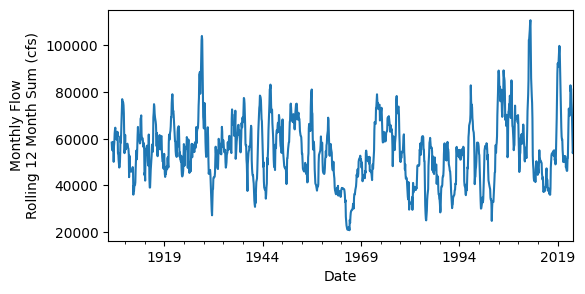

In [2]:
### Load demo data
Q_obs = load_example_data()
test_site_idx = 0
test_site_name = Q_obs.columns[test_site_idx]

Q_obs = Q_obs.iloc[:, test_site_idx].dropna()
Q_obs = Q_obs.loc[Q_obs > 0]
Q_obs_monthly = Q_obs.resample('MS').sum()

Q_test = Q_obs.copy()
Q_obs_monthly = Q_obs_monthly #.iloc[:, test_site_idx].dropna()
Q_obs_monthly = Q_obs_monthly[Q_obs_monthly > 0]
(Q_obs_monthly<0).sum()

TEST_N_REALIZATIONS = 100
TEST_N_MONTHS = 12*100

Q_syn_KN = pd.read_csv('../outputs/Kirsh_Q_syn.csv', 
                       index_col=0, parse_dates=True)
new_daterange = pd.date_range(start=Q_obs_monthly.index[0],
                              periods=len(Q_syn_KN), freq='MS')
Q_syn_KN.index = new_daterange

fig, ax = plt.subplots(figsize=(6, 3))
Q_obs_monthly.rolling(12).sum().plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Flow\nRolling 12 Month Sum (cfs)')

In [49]:
Q_obs_monthly.index

DatetimeIndex(['1904-10-01', '1904-11-01', '1904-12-01', '1905-01-01',
               '1905-02-01', '1905-03-01', '1905-04-01', '1905-05-01',
               '1905-06-01', '1905-07-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', length=1419, freq='MS')

Calculating SSI for obs...


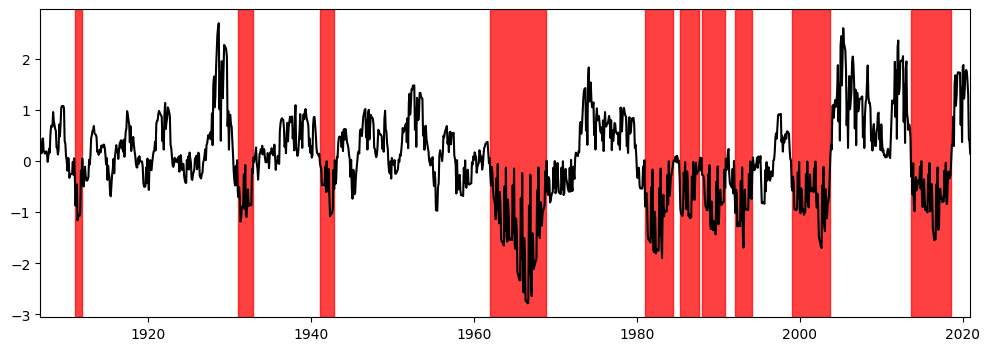

In [52]:
import numpy as np
import pandas as pd
import spei as si
import scipy.stats as scs


def aggregate_and_rolling_sum(Q_i,
                              window, 
                              aggregate = None):
    if aggregate is not None:
        Q_i = Q_i.resample(aggregate).sum()
    Q_i = Q_i.rolling(window).sum().iloc[window:, :].dropna()
    Q_i = Q_i.iloc[:-window, :]
    return Q_i
    

def calculate_ssi_values(data, 
                         window,
                         nodes,
                         aggregate = None):
    
    ssi = {}
    models = list(data.keys())
    
    for m in models:
        print(f'Calculating SSI for {m}...')
        if 'ensemble' in m:
            real_keys = list(data[m].keys())
            ssi[m] = {}
            for r in real_keys:
                Q_ri = data[m][r][nodes]
                Q_ri = aggregate_and_rolling_sum(Q_ri, window, aggregate)
                
                ssi[m][r] = pd.DataFrame(index = Q_ri.index, columns=nodes)
                for n in nodes:
                    ssi[m][r][n] = si.ssfi(Q_ri[n], dist=scs.gamma)
        else:
            Q_i = data[m][nodes]
            Q_i = aggregate_and_rolling_sum(Q_i, window, aggregate)
            
            ssi[m] = pd.DataFrame(index = Q_i.index, columns=nodes)
            for n in nodes:
                ssi[m][n] = si.ssfi(Q_i[n], dist=scs.gamma)
    
    return ssi




def get_drought_metrics(ssi):
    """Get drought start and end dates, magnitude, severity, and duration.

    Args:
        ssi (pd.Series): Array of SSI values.  

    Returns:
        pd.DataFrame: DataFrame containing all drought metrics for each drought period.
    """
    
    drought_data = {}
    drought_counter = 0
    in_critical_drought = False
    drought_days = []

    for ind in range(len(ssi)):
        if ssi.values[ind] < 0:
            drought_days.append(ind)
            
            if ssi.values[ind] <= -1:
                in_critical_drought = True
        else:
            # Record drought info once it ends
            if in_critical_drought:
                drought_counter += 1
                drought_data[drought_counter] = {
                    'start':ssi.index[drought_days[0]],
                    'end': ssi.index[drought_days[-1]],
                    'duration': len(drought_days),
                    'magnitude': sum(ssi.values[drought_days]),
                    'severity': min(ssi.values[drought_days])
                }
            
            # Reset counters
            in_critical_drought = False
            drought_days = [] 

    drought_metrics = pd.DataFrame(drought_data).transpose()
    return drought_metrics

Q_obs_ssi = calculate_ssi_values({'obs':pd.DataFrame(Q_obs_monthly.values, 
                                                     columns=['site'], 
                                                     index=Q_obs_monthly.index)}, 
                                 window=24, nodes=['site'])
obs_droughts = get_drought_metrics(Q_obs_ssi['obs'])

def plot_drought_periods(ssi, droughts):
    
    fig, ax = plt.subplots(figsize=(12, 4))
    for drought_period in droughts.iterrows():
        start = drought_period[1]['start']
        end = drought_period[1]['end']
        start_date = pd.to_datetime(start)
        end_date = pd.to_datetime(end)
        ax.axvspan(start_date, 
                   end_date, color='r', alpha=0.75)
    ax.plot(ssi, color='k', label='SSI')
    ax.set_xlim(ssi.index[0], ssi.index[-1])
    # plt.yscale('log')
    plt.show()
    return

plot_drought_periods(Q_obs_ssi['obs'], obs_droughts)

In [64]:
# obs_droughts = get_drought_metrics(Q_obs_ssi['obs'])
# Q_syn_ssi = calculate_ssi_values({'syn':Q_syn_KN}, 
#                                  window=24, 
#                                  nodes=Q_syn_KN.columns.tolist())

ssi = {}
ssi['obs'] = Q_obs_ssi['obs']
ssi['syn_ensemble'] = {}

realizations = Q_syn_KN.columns
realization_numbers = [int(r.split('_')[-1]) for r in realizations]

for i, r in enumerate(realization_numbers):
    if i ==0:
        syn_droughts = get_drought_metrics(ssi['syn_ensemble'][r][target_node])
        syn_droughts['realization'] = r
        obs_droughts = get_drought_metrics(ssi['obs']['delTrenton'])
    else:
        real_syn_droughts = get_drought_metrics(ssi['pywr_syn_obs_pub_nhmv10_ObsScaled_ensemble'][r][target_node])
        real_syn_droughts['realization'] = r
        syn_droughts = pd.concat([syn_droughts, real_syn_droughts], axis=0)
        

Q_syn_ssi_ensemble = {}
Q_syn_ssi_ensemble['syn_ensemble'] = {}
for col in Q_syn_KN.columns:
    Q_syn_ssi_ensemble['syn_ensemble'][col] = Q_syn_ssi['syn'][col]

Q_syn_droughts = get_drought_metrics(Q_syn_ssi_ensemble['syn_ensemble'])

drought_metric_scatter_plot(obs_droughts, 
                            Q_syn_droughts)

TypeError: 'builtin_function_or_method' object is not subscriptable

[[0.04444245 0.05165668 0.0521088  0.05158632 0.05045798 0.04928383
  0.05001841 0.05147393 0.05219894 0.05208538 0.04971649]
 [0.04260577 0.05101978 0.05207395 0.05200684 0.05128352 0.05038068
  0.05096393 0.05198065 0.05220923 0.05163271 0.04845434]]


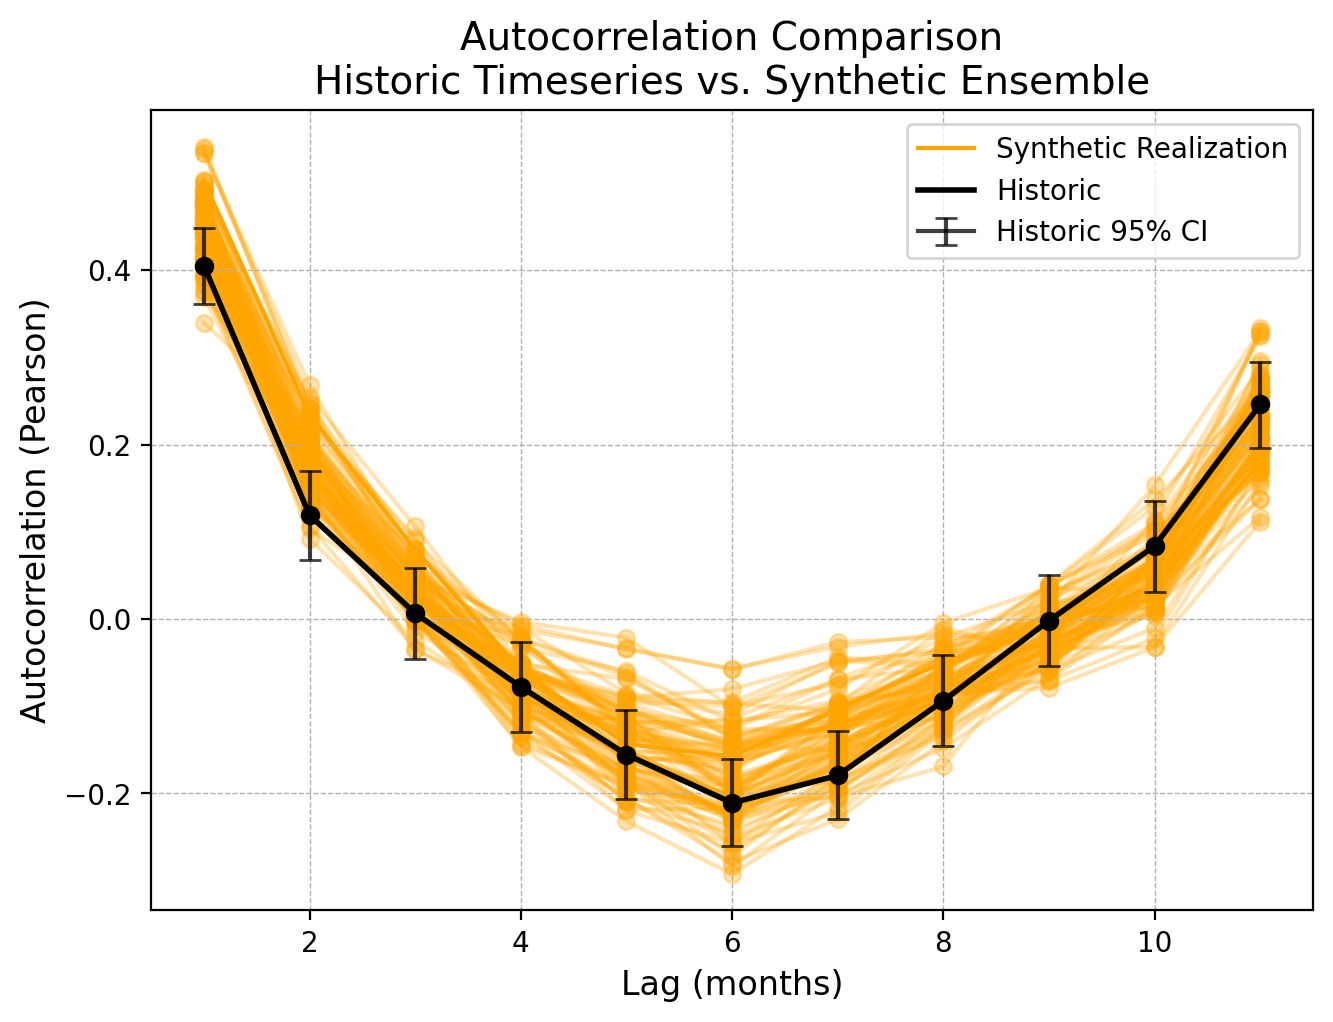

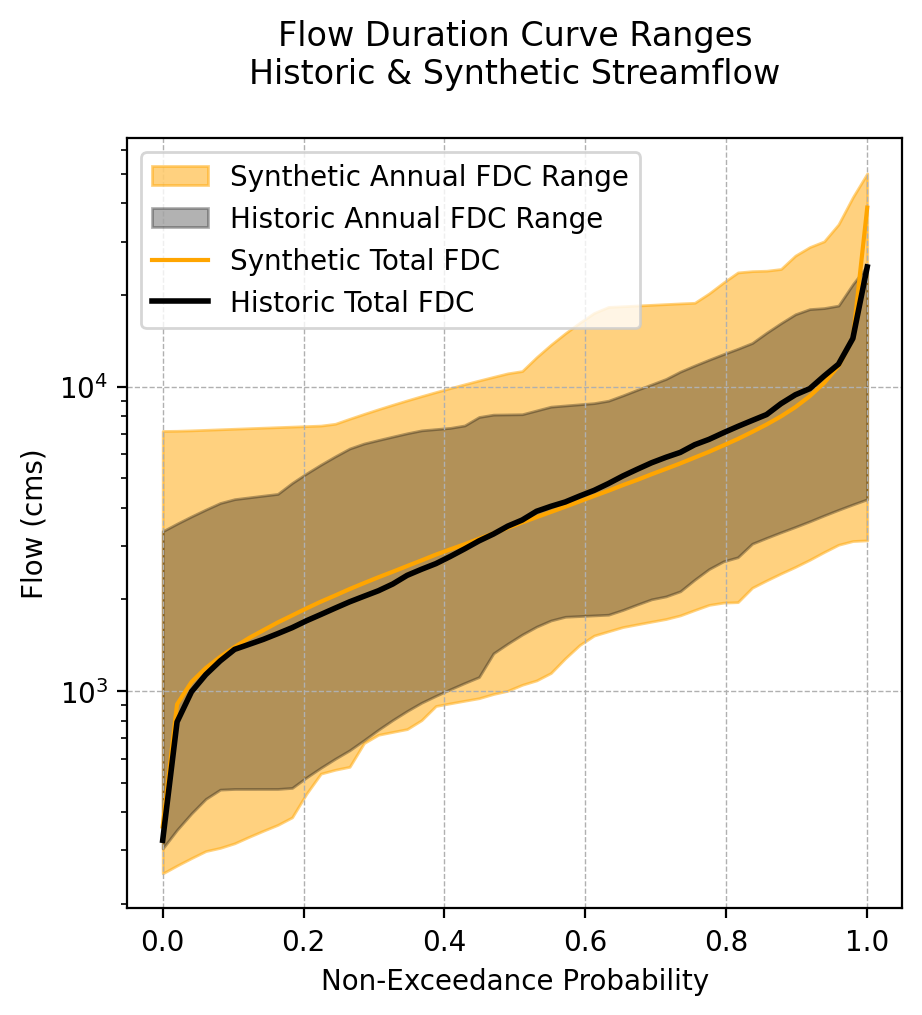

In [36]:
plot_autocorrelation(Q_obs_monthly, Q_syn_KN, lag_range=np.arange(1,12), timestep='monthly')

plot_fdc_ranges(Q_obs_monthly, Q_syn_KN)



xs: Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       357, 358, 359, 360, 361, 362, 363, 364, 365, 366],
      dtype='int32', length=366) 

 s_min: 1      1434.905289
32      805.133853
60      432.802319
61      465.203729
91      449.148846
92      251.444366
121     306.519170
122     354.004558
152     347.095501
153     320.315399
182     287.025942
183     444.230380
213     443.561451
214     608.713192
244     855.995297
245     740.544431
274     406.230401
275     826.184831
305     774.185432
306     735.673552
335    1959.757842
336    1858.607722
dtype: float64 




ValueError: operands could not be broadcast together with shapes (366,) (22,) 

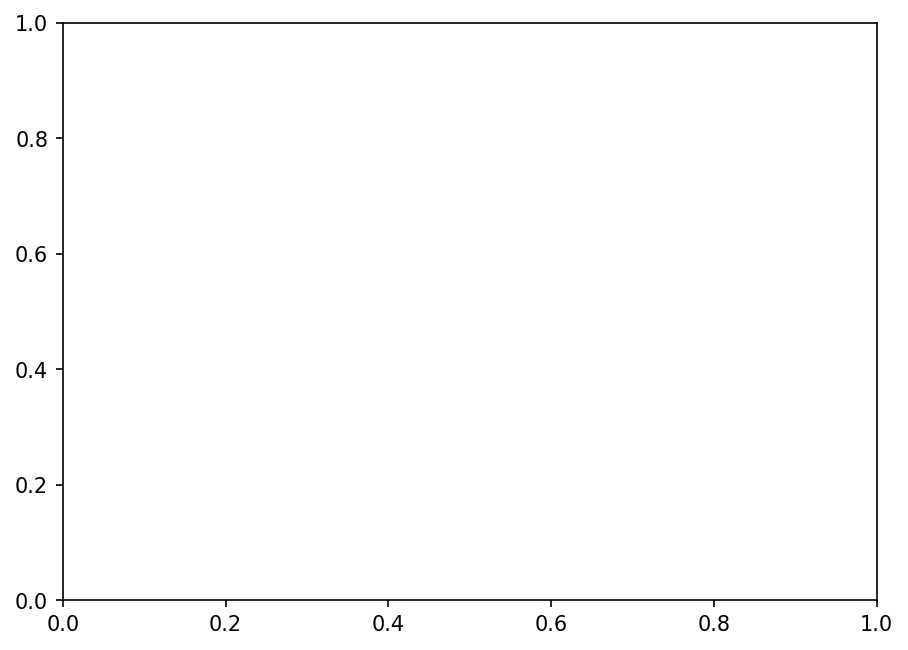

In [45]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def plot_flow_ranges(Qh, Qs, 
                     timestep = 'daily',
                     units = 'cms', y_scale = 'log',
                     savefig = False, fig_dir = '.',
                     figsize = (7,5), colors = ['black', 'orange'],
                     title_addon = ""):
    """Plots the range of flow for historic and syntehtic streamflows for a specific timestep scale.
     
    Args:
        Qh (pd.Series): Historic daily streamflow timeseries. Index must be pd.DatetimeIndex. 
        Qs (pd.DataFrame): Synthetic daily streamflow timeseries realizations. Each column is a unique realization. Index must be pd.DatetimeIndex.
        timestep (str, optional): The timestep which data should be aggregated over. Defaults to 'daily'. Options are 'daily', 'weekly', or 'monthly'.
        units (str, optional): Streamflow units, for axis label. Defaults to 'cms'.
        y_scale (str, optional): Scale of the y-axis. Defaults to 'log'.
        savefig (bool, optional): Allows for png to be saved to fig_dir. Defaults to False.
        fig_dir (str, optional): Location of saved figure output. Defaults to '.' (working directory).
        figsize (tuple, optional): The figure size. Defaults to (4,4).
        colors (list, optional): List of two colors for historic and synthetic data respectively. Defaults to ['black', 'orange'].
        title_addon (str, optional): Text to be added to the end of the title. Defaults to "".
    """
 
    # Assert formatting matches expected
    assert(type(Qh.index) == pd.DatetimeIndex), 'Historic streamflow (Qh) should have pd.DatatimeIndex.'
    assert(type(Qs.index) == pd.DatetimeIndex), 'Synthetic streamflow (Qh) should have pd.DatatimeIndex.'
 
    # Handle conditional datetime formatting
    if timestep == 'daily':
        h_grouper = Qh.index.dayofyear
        s_grouper = Qs.index.dayofyear
        x_lab = 'Day of the Year (Jan-Dec)'
    elif timestep == 'monthly':
        h_grouper = Qh.index.month
        s_grouper = Qs.index.month
        x_lab = 'Month of the Year (Jan-Dec)'
    elif timestep == 'weekly':
        h_grouper = pd.Index(Qh.index.isocalendar().week, dtype = int)
        s_grouper = pd.Index(Qs.index.isocalendar().week, dtype = int)
        x_lab = 'Week of the Year (Jan-Dec)'
    else:
        print('Invalid timestep input. Options: "daily", "monthly", "weekly".')
        return
 
    # Find flow ranges
    s_max = Qs.groupby(s_grouper).max().max(axis=1)
    s_min = Qs.groupby(s_grouper).min().min(axis=1)
    s_median = Qs.groupby(s_grouper).median().median(axis=1)
    h_max = Qh.groupby(h_grouper).max()
    h_min = Qh.groupby(h_grouper).min()
    h_median = Qh.groupby(h_grouper).median()
   
    ## Plotting  
    fig, ax = plt.subplots(figsize = figsize, dpi=150)
    xs = h_max.index
    print(f'xs: {xs} \n\n s_min: {s_min} \n\n')
    ax.fill_between(xs, s_min, s_max, color = colors[1], label = 'Synthetic Range', alpha = 0.5)
    ax.plot(xs, s_median, color = colors[1], label = 'Synthetic Median')
    ax.fill_between(xs, h_min, h_max, color = colors[0], label = 'Historic Range', alpha = 0.3)
    ax.plot(xs, h_median, color = colors[0], label = 'Historic Median')
     
    ax.set_yscale(y_scale)
    ax.set_ylabel(f'{timestep.capitalize()} Flow ({units})', fontsize=12)
    ax.set_xlabel(x_lab, fontsize=12)
    ax.legend(ncols = 2, fontsize = 10, bbox_to_anchor = (0, -.5, 1.0, 0.2), loc = 'upper center')    
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.set_title(f'{timestep.capitalize()} Streamflow Ranges\nHistoric & Synthetic Timeseries at One Location\n{title_addon}')
    plt.tight_layout()
     
    if savefig:
        plt.savefig(f'{fig_dir}/flow_ranges_{timestep}.png', dpi = 150)
    return


plot_flow_ranges(Q_obs, Q_syn_KN, timestep='daily')
# Q_obs

In [46]:
Q_obs

1904-10-01    155.742656
1904-10-02    118.930756
1904-10-03    101.940648
1904-10-04     90.613909
1904-10-05     79.287170
                 ...    
2022-12-27    223.986257
2022-12-28    194.536736
2022-12-29    170.184248
2022-12-30    152.061466
2022-12-31    150.645624
Name: USGS-01434000, Length: 43191, dtype: float64

In [48]:
Q_syn_KN.index

DatetimeIndex(['1904-10-01', '1904-11-01', '1904-12-01', '1905-01-01',
               '1905-02-01', '1905-03-01', '1905-04-01', '1905-05-01',
               '1905-06-01', '1905-07-01',
               ...
               '1975-12-01', '1976-01-01', '1976-02-01', '1976-03-01',
               '1976-04-01', '1976-05-01', '1976-06-01', '1976-07-01',
               '1976-08-01', '1976-09-01'],
              dtype='datetime64[ns]', length=864, freq='MS')

## ThomasFiering Model



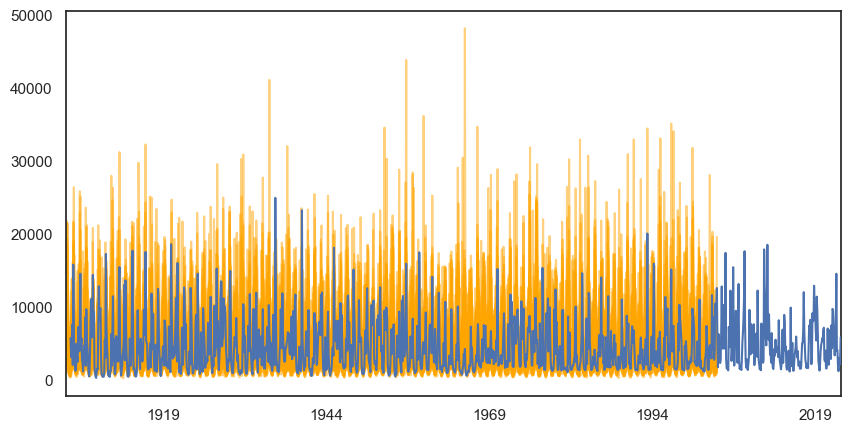

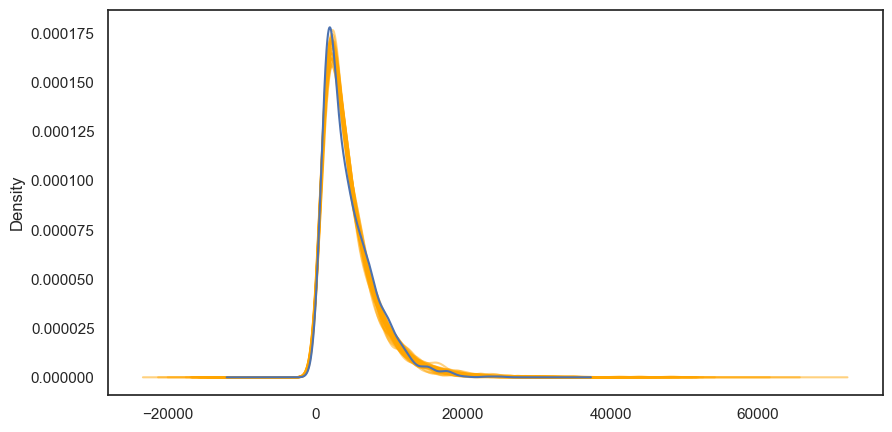

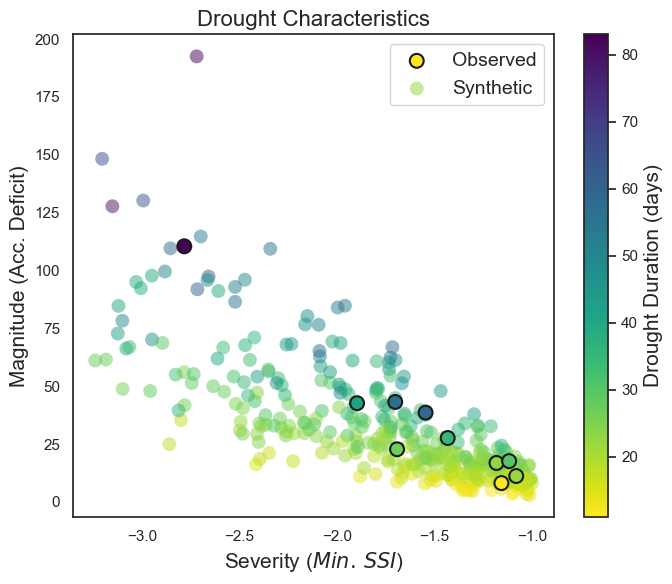

[[0.04444245 0.05165668 0.0521088  0.05158632 0.05045798 0.04928383
  0.05001841 0.05147393 0.05219894 0.05208538 0.04971649]
 [0.04260577 0.05101978 0.05207395 0.05200684 0.05128352 0.05038068
  0.05096393 0.05198065 0.05220923 0.05163271 0.04845434]]


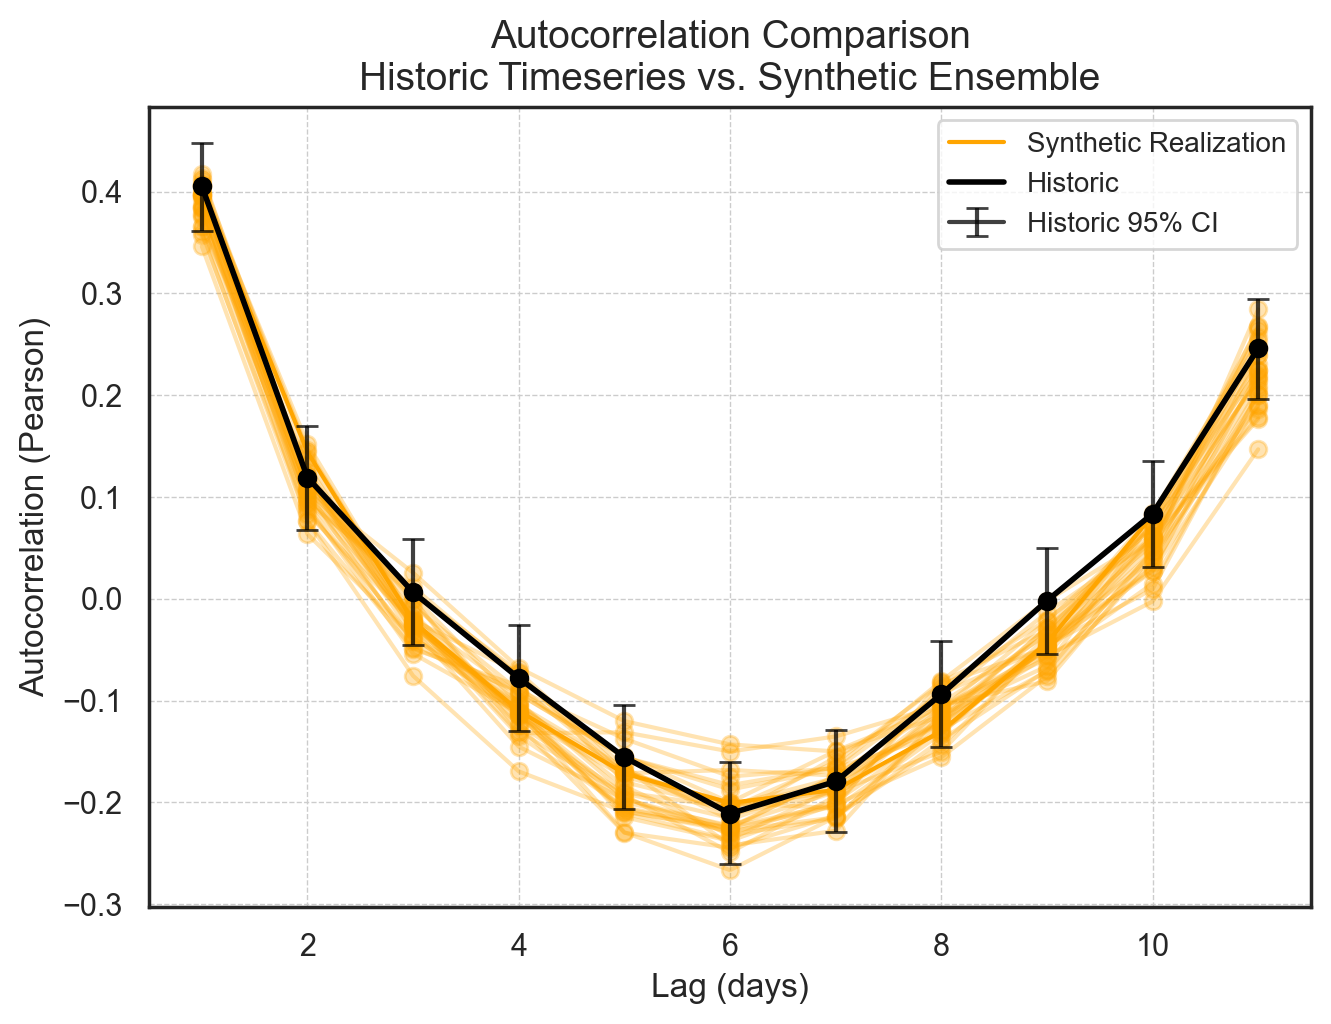

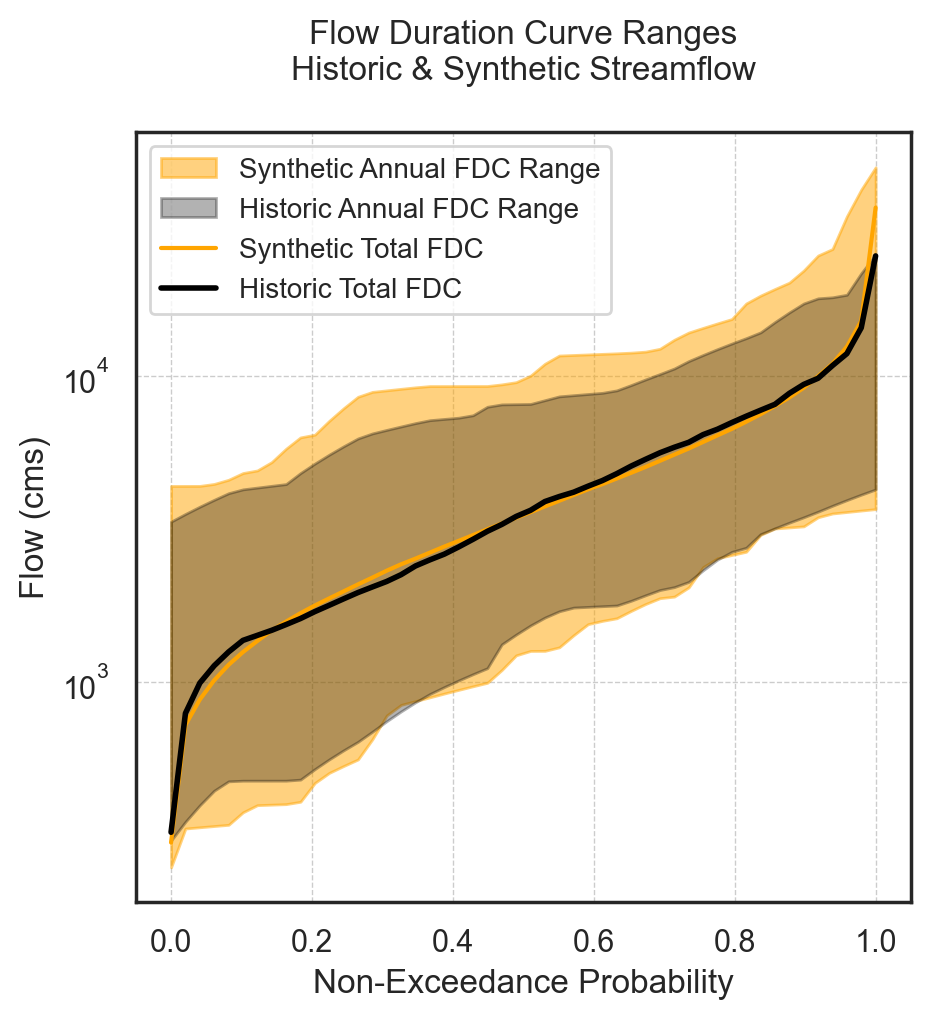

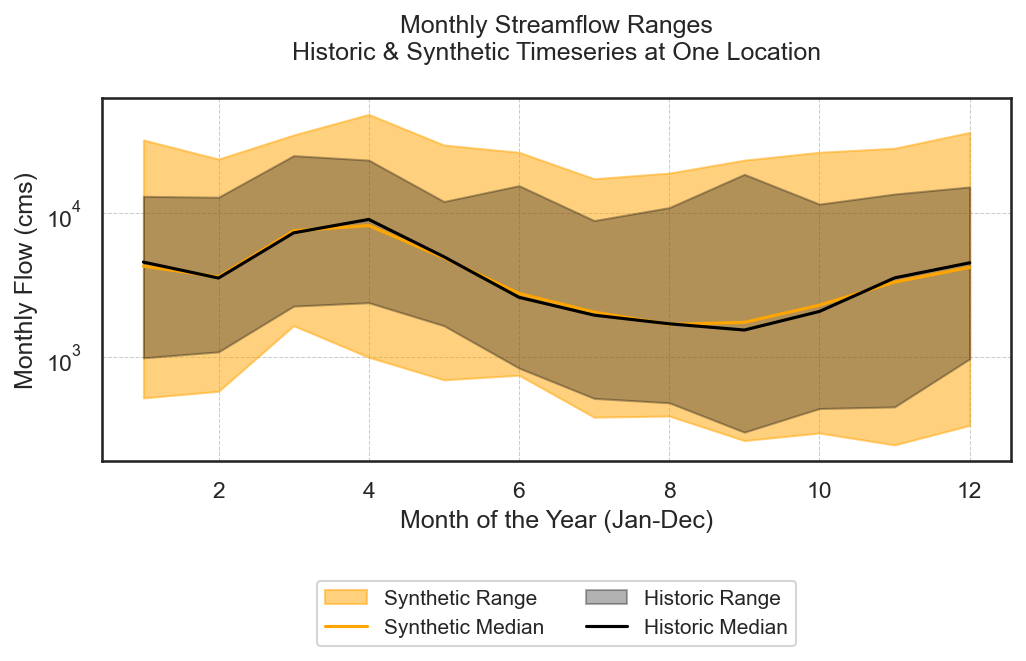

In [15]:
## ThomasFiering Model
tf = ThomasFieringGenerator(Q_obs_monthly)
Q_syn = tf.generate(n_years=100, n_realizations=30)
Q_syn_tf = Q_syn.copy()

tf.plot(kind='ts')
tf.plot(kind='kde')

drought_metric_scatter_plot(get_drought_metrics(Q_obs_monthly, window=24), 
                            get_drought_metrics(Q_syn, window=24))

plot_autocorrelation(Q_obs_monthly, Q_syn, lag_range=np.arange(1,12), timestep='daily')

plot_fdc_ranges(Q_obs_monthly, Q_syn)

plot_flow_ranges(Q_obs_monthly, Q_syn, timestep='monthly')

## Hidden Markov Model


Using default value False for kwarg standardize.
Using default value False for kwarg normalize.
Using default value MS for kwarg timestep.
Using default value False for kwarg _is_fit.
Using default value False for kwarg _is_preprocessed.
Using default value False for kwarg verbose.
Preprocessing data.
Plotting PDF of state 1
Plotting PDF of state 2


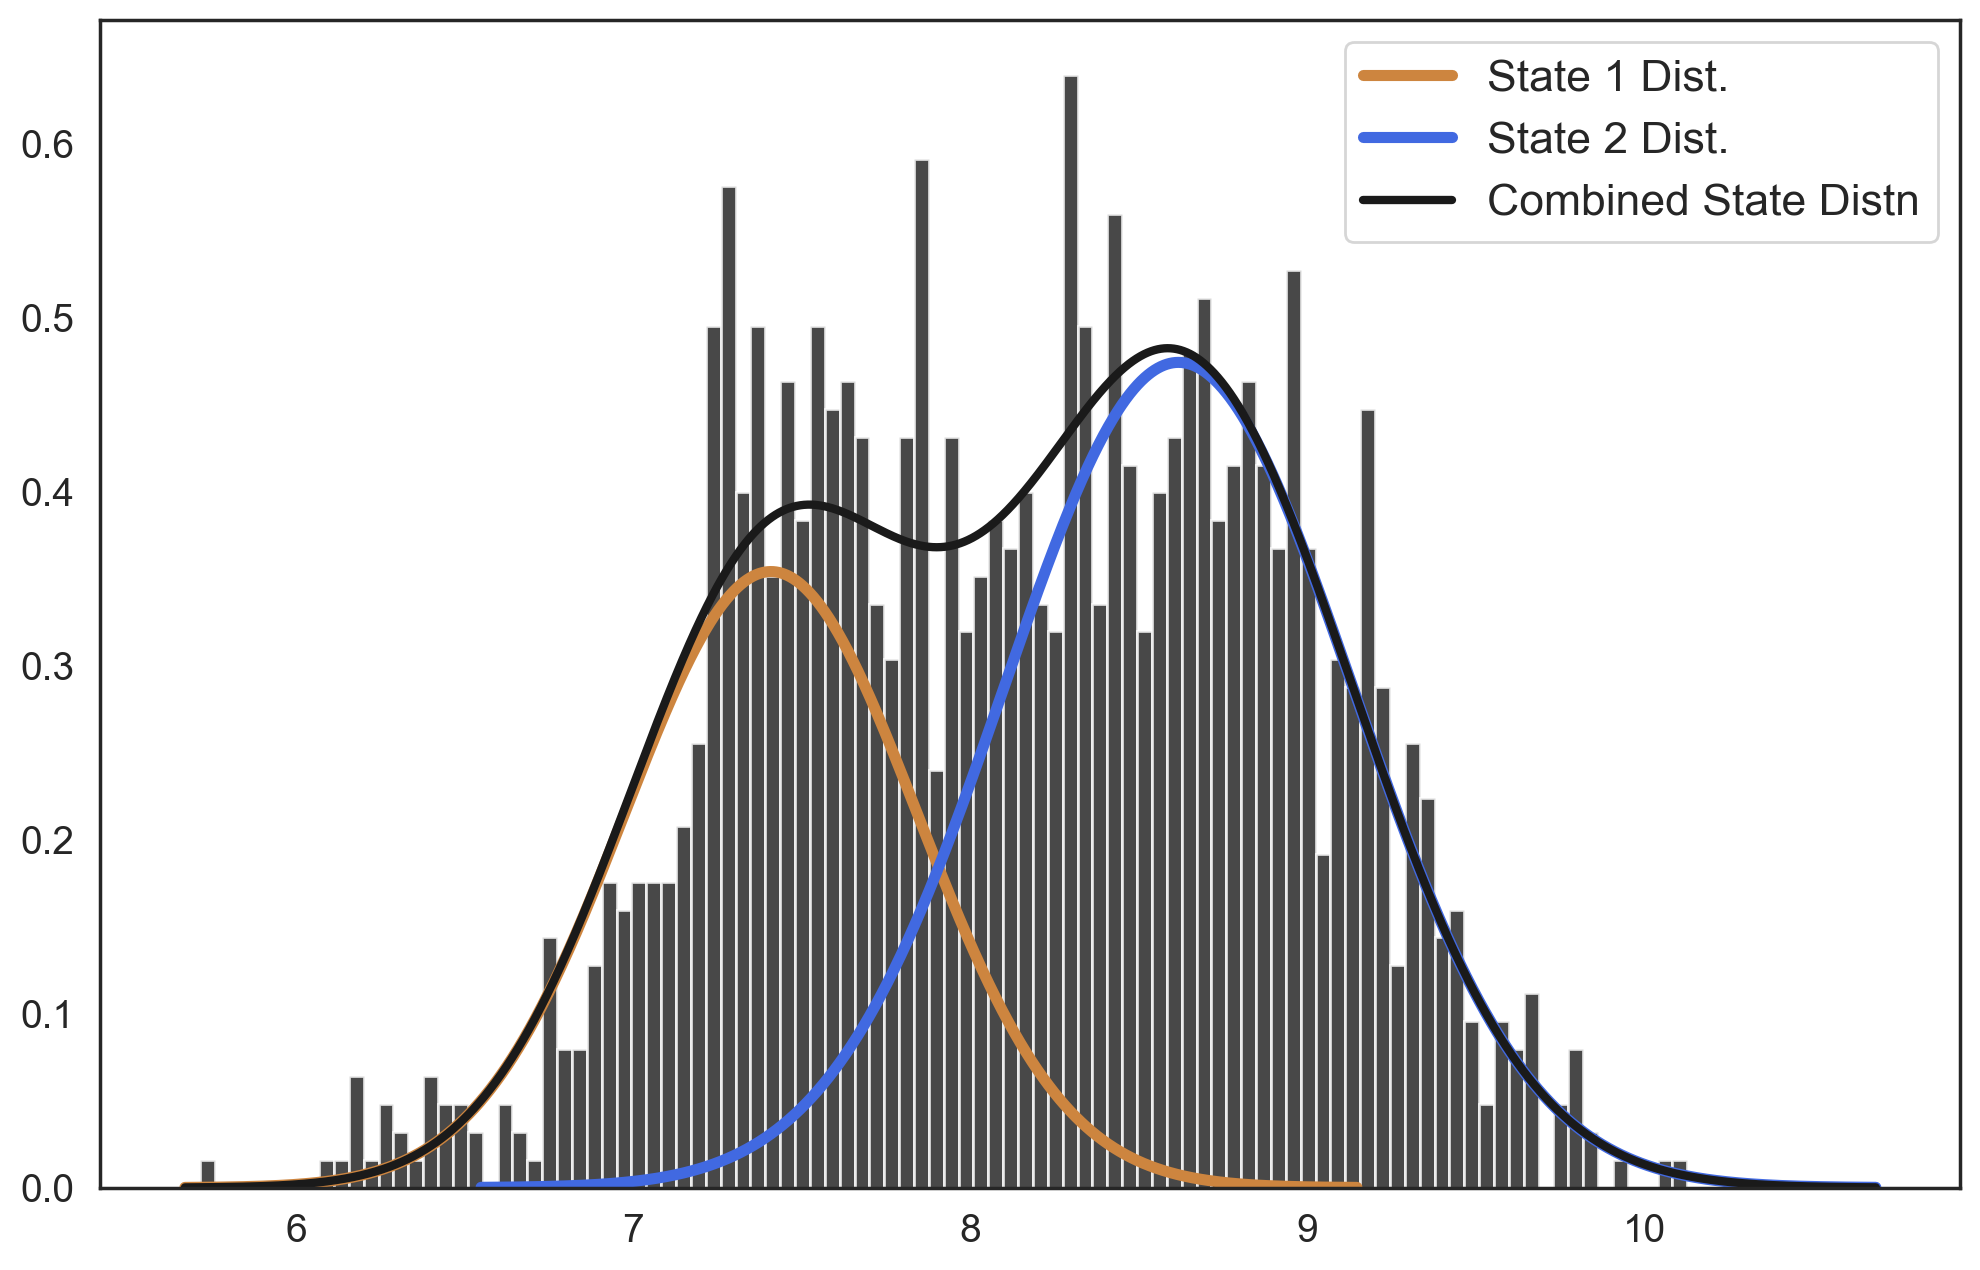

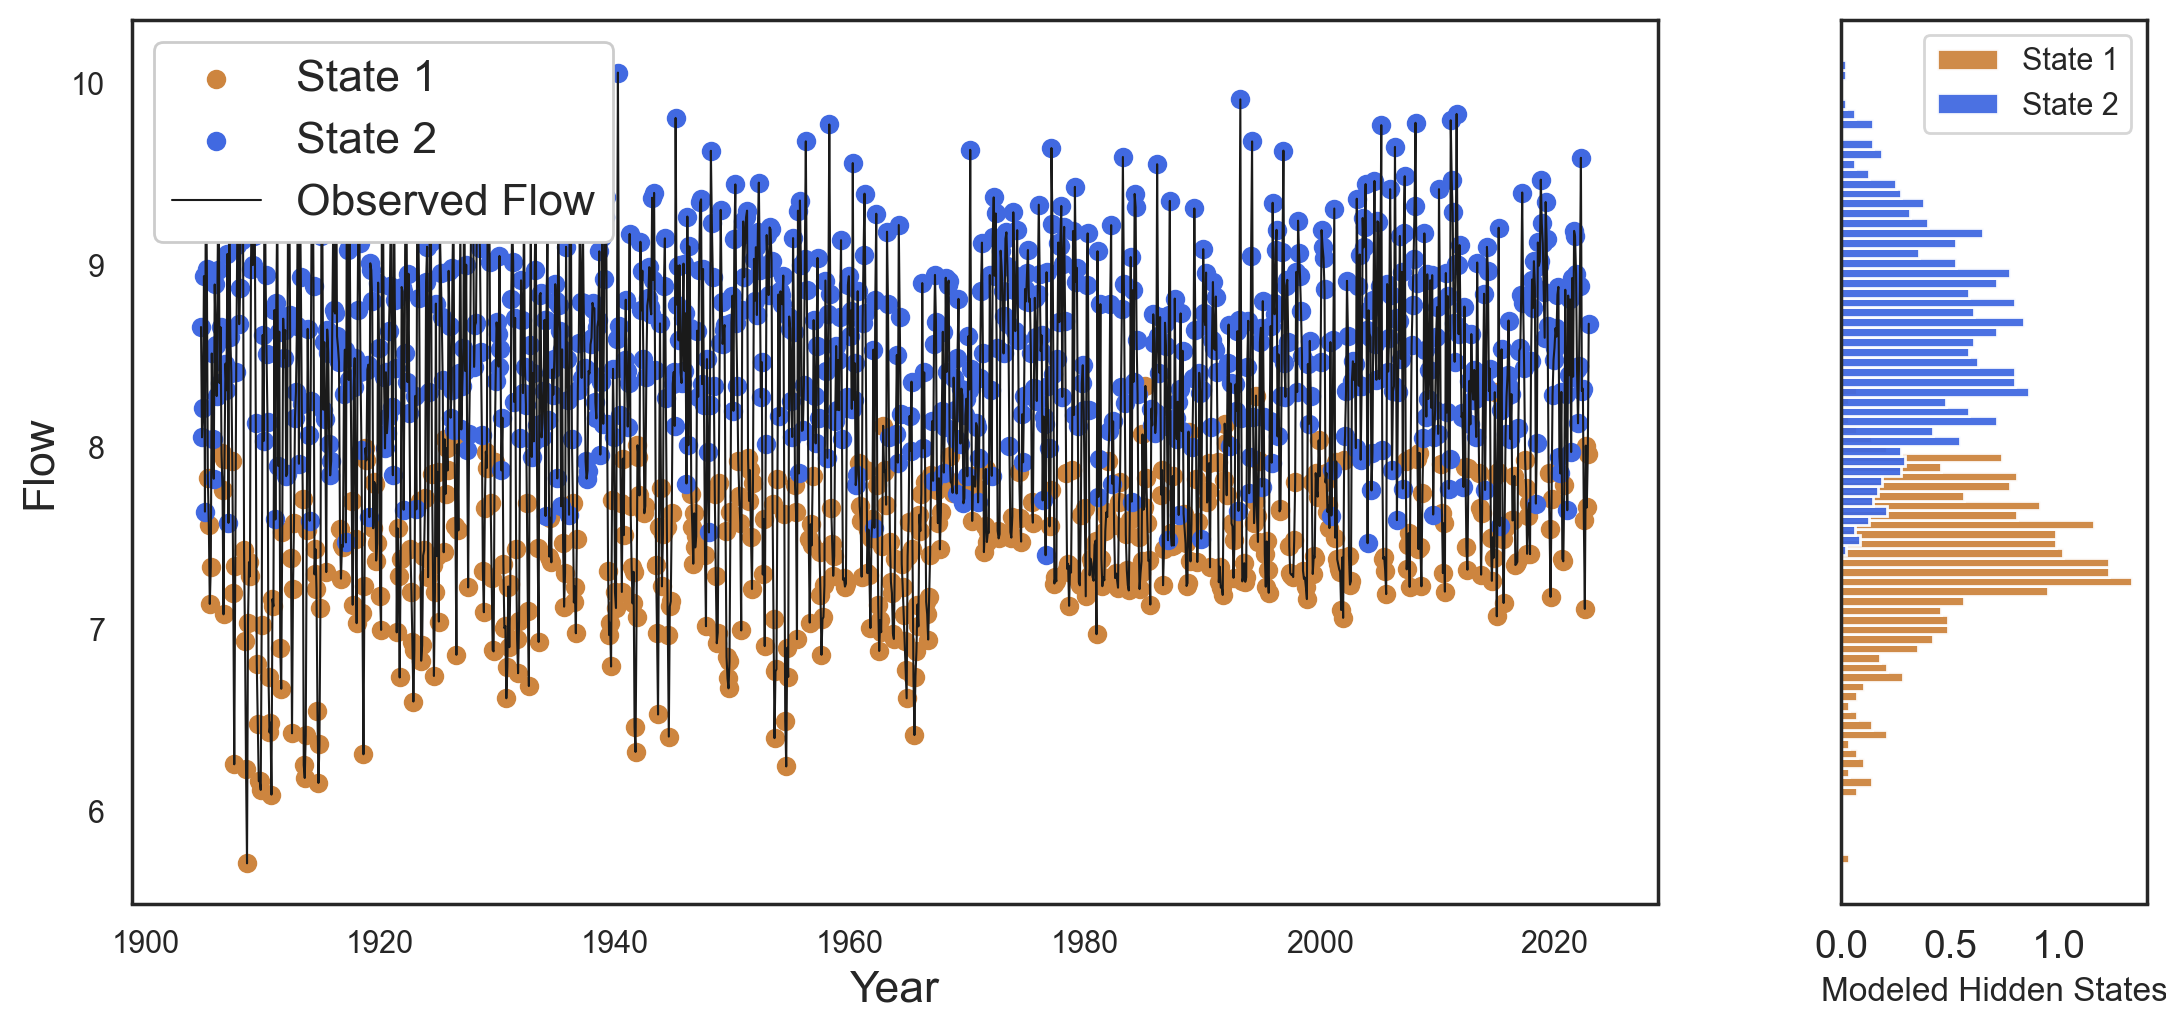

0

In [12]:

aggregation = 'MS'
Q_test_agg = Q_test.resample(aggregation).sum()


model = HMM(Q_test_agg, 
            n_timesteps=(12*70),
            n_hidden_states=2, n_realizations=TEST_N_REALIZATIONS, 
            max_iter=5000, tolerance=1e-16,
            deseasonalize=False,
            log_transform=True)
model.fit()

Q_syn = model.generate()
for c in Q_syn.columns:
    Q_syn[c] = Q_syn[c] 
model.plot(kind='dist')

# model.Q_train = model.Q_train.loc['1960-01-01':'1970-01-01']
model.plot()
(Q_test_agg<0).sum()


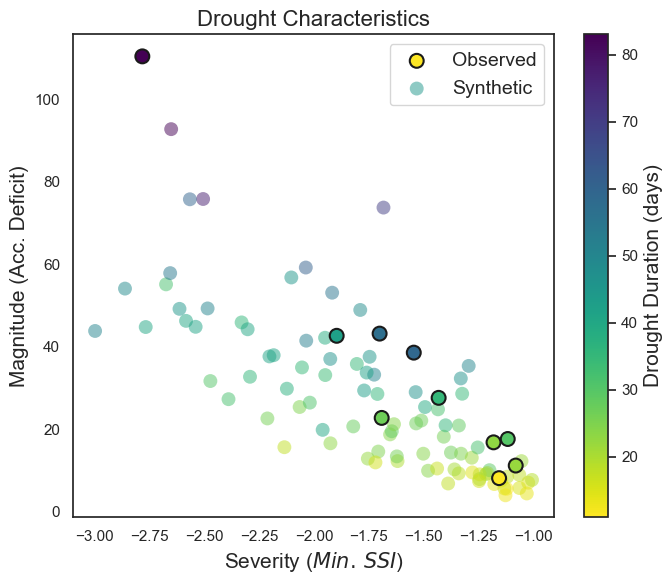

[[0.04444245 0.05165668 0.0521088  0.05158632 0.05045798 0.04928383
  0.05001841 0.05147393 0.05219894 0.05208538 0.04971649]
 [0.04260577 0.05101978 0.05207395 0.05200684 0.05128352 0.05038068
  0.05096393 0.05198065 0.05220923 0.05163271 0.04845434]]


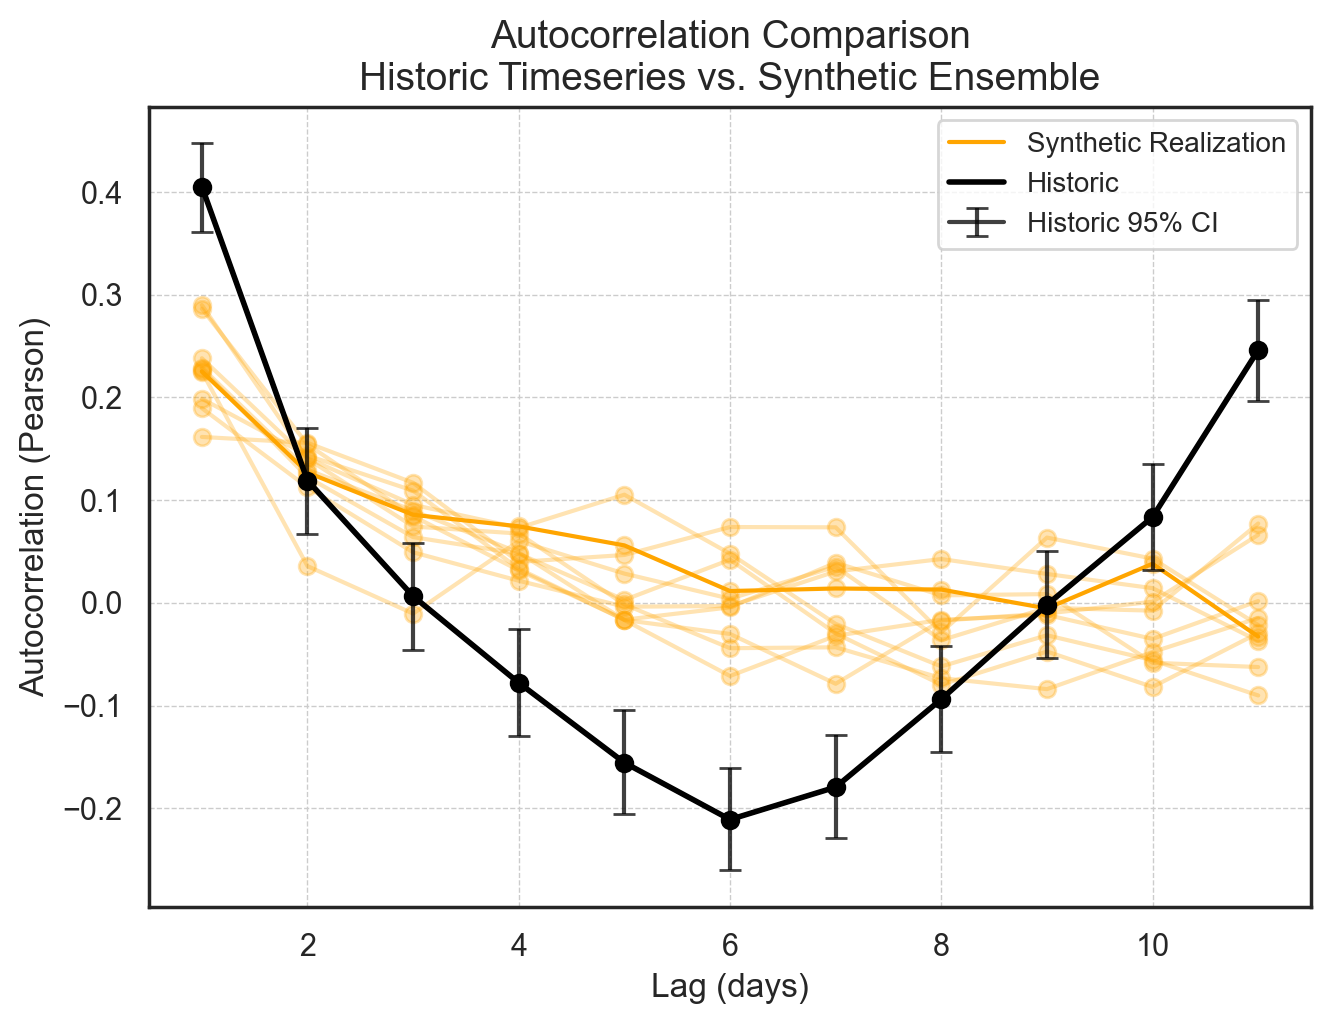

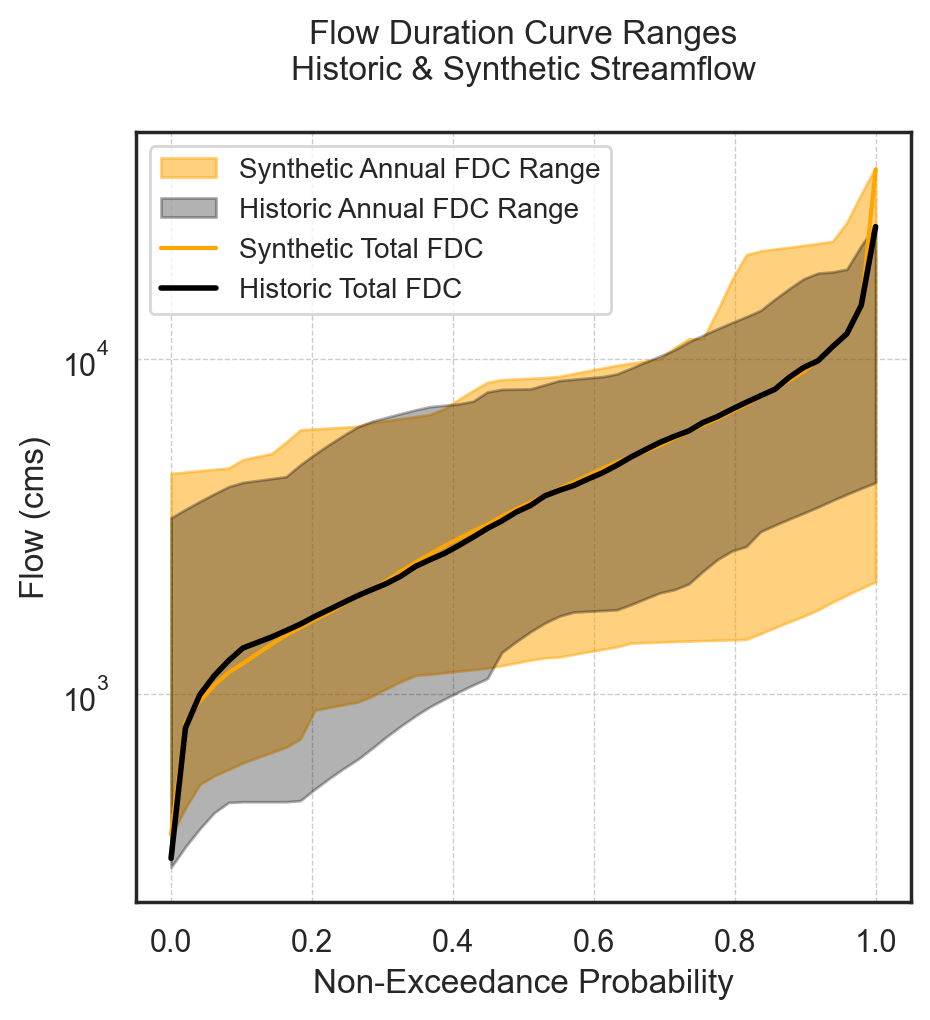

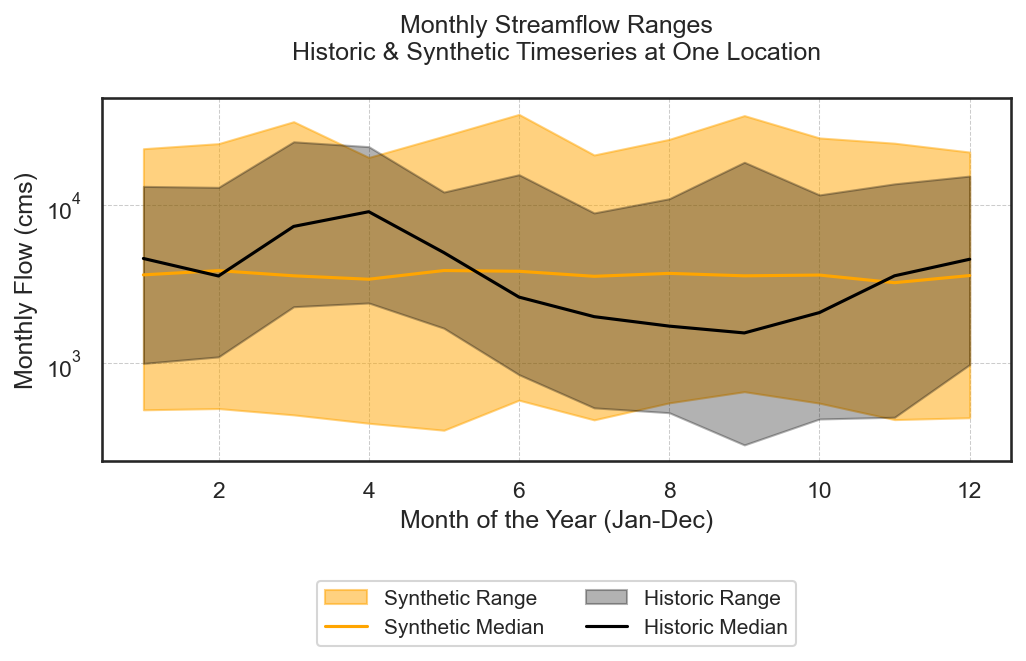

In [13]:
drought_metric_scatter_plot(get_drought_metrics(Q_obs_monthly, window=24), 
                            get_drought_metrics(Q_syn, window=24))

plot_autocorrelation(Q_obs_monthly, Q_syn, lag_range=np.arange(1,12), timestep='daily')

plot_fdc_ranges(Q_obs_monthly, Q_syn)

plot_flow_ranges(Q_obs_monthly, Q_syn, timestep='monthly')